In [25]:
# Import packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.metrics import mean_squared_error

import pickle

In [26]:
## Reading the yellow trip 2022-01 data

data = pd.read_parquet('./data/yellow_tripdata_2022-01.parquet')

In [27]:
## Number of rows and columns in data

data.shape

(2463931, 19)

In [28]:
data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [29]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [30]:
## Feature engineering "duration" column and converting the values of that column to minutes.

data['duration'] = data.tpep_dropoff_datetime - data.tpep_pickup_datetime
data['duration'] = data.duration.apply(lambda td: td.total_seconds()/60)

In [31]:
## Standard deviation of the duration column

data['duration'].std()

46.44530513776499

/Users/ayaz/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='duration'>

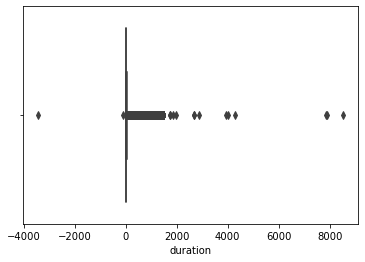

In [10]:
sns.boxplot(data['duration'])

/Users/ayaz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

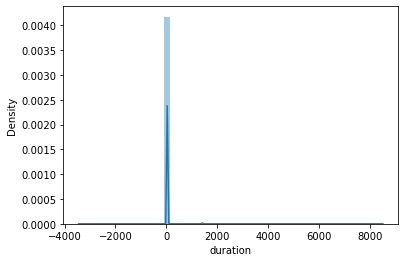

In [13]:
sns.distplot(data['duration'], hist=True)

In [32]:
## Removing the outlier by removing the considering the duration minutes greater than 1 and less than 60

Outlier = data[(data['duration']>1) & (data['duration']<=60)]

In [33]:
Outlier

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0,17.816667
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0,8.400000
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0,8.966667
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0,10.033333
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0,37.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN,5.966667
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN,10.650000
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN,11.000000
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN,12.050000


In [34]:
### Fraction of the records left after dropping the outliers

len(Outlier['duration'])/len(data['duration']) * 100

98.26216724413143

### Dimensionality after One Hot Encoding

In [35]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

Outlier[categorical] = Outlier[categorical].astype(str)

dv = DictVectorizer()

train_dicts = Outlier[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

/var/folders/52/10q7kld55jzg1xfhgdgkppq40000gn/T/ipykernel_1781/601622624.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Outlier[categorical] = Outlier[categorical].astype(str)


In [36]:
data.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
duration                        float64
dtype: object

In [37]:
X_train

<2421112x516 sparse matrix of type '<class 'numpy.float64'>'
	with 7263336 stored elements in Compressed Sparse Row format>

In [38]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=105',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',

In [39]:
target = 'duration'
y_train = Outlier[target].values

In [40]:
### Initializing the Linear Regression Model

lr = LinearRegression()

In [41]:
### Training the model

lr.fit(X_train, y_train)

LinearRegression()

In [42]:
### Predicting the values and calculating the mean_squared_error

y_pred = lr.predict(X_train)
mean_squared_error(y_train, y_pred, squared=False)

6.984885464786887

In [121]:
### Reading the validation data (Yellow trip data 2022-02)

val_data = pd.read_parquet('./data/yellow_tripdata_2022-02.parquet')

In [122]:
val_data['duration'] = val_data.tpep_dropoff_datetime - val_data.tpep_pickup_datetime
val_data['duration'] = val_data.duration.apply(lambda td: td.total_seconds()/60)

In [123]:
val_data = val_data.dropna()

In [124]:
val_data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,1,2022-02-01 00:06:58,2022-02-01 00:19:24,1.0,5.40,1.0,N,138,252,1,17.0,1.75,0.5,3.90,0.00,0.3,23.45,0.0,1.25,12.433333
1,1,2022-02-01 00:38:22,2022-02-01 00:55:55,1.0,6.40,1.0,N,138,41,2,21.0,1.75,0.5,0.00,6.55,0.3,30.10,0.0,1.25,17.550000
2,1,2022-02-01 00:03:20,2022-02-01 00:26:59,1.0,12.50,1.0,N,138,200,2,35.5,1.75,0.5,0.00,6.55,0.3,44.60,0.0,1.25,23.650000
3,2,2022-02-01 00:08:00,2022-02-01 00:28:05,1.0,9.88,1.0,N,239,200,2,28.0,0.50,0.5,0.00,3.00,0.3,34.80,2.5,0.00,20.083333
4,2,2022-02-01 00:06:48,2022-02-01 00:33:07,1.0,12.16,1.0,N,138,125,1,35.5,0.50,0.5,8.11,0.00,0.3,48.66,2.5,1.25,26.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2877688,1,2022-02-28 23:46:51,2022-02-28 23:54:36,2.0,1.70,1.0,N,100,142,1,8.0,3.00,0.5,3.50,0.00,0.3,15.30,2.5,0.00,7.750000
2877689,2,2022-02-28 23:03:32,2022-02-28 23:11:37,1.0,1.51,1.0,N,116,247,2,7.5,0.50,0.5,0.00,0.00,0.3,8.80,0.0,0.00,8.083333
2877690,2,2022-02-28 23:15:13,2022-02-28 23:23:25,1.0,1.20,1.0,N,230,170,1,7.5,0.50,0.5,2.26,0.00,0.3,13.56,2.5,0.00,8.200000
2877691,2,2022-02-28 23:33:22,2022-02-28 23:56:45,1.0,5.62,1.0,N,114,239,1,20.5,0.50,0.5,4.86,0.00,0.3,29.16,2.5,0.00,23.383333


In [125]:
val_data = val_data[(val_data['duration']>1) & (val_data['duration']<=60)]

In [128]:
val_data.shape

(2822194, 20)

In [129]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

val_data[categorical] = val_data[categorical].astype(str)

dv = DictVectorizer()

val_dicts = val_data[categorical + numerical].to_dict(orient='records')
val_train = dv.fit_transform(val_dicts)

/var/folders/52/10q7kld55jzg1xfhgdgkppq40000gn/T/ipykernel_1781/3842851427.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data[categorical] = val_data[categorical].astype(str)


In [130]:
val_train

<2822194x514 sparse matrix of type '<class 'numpy.float64'>'
	with 8466582 stored elements in Compressed Sparse Row format>

In [131]:
val_data['trip_distance']

0           5.40
1           6.40
2          12.50
3           9.88
4          12.16
           ...  
2877688     1.70
2877689     1.51
2877690     1.20
2877691     5.62
2877692     1.90
Name: trip_distance, Length: 2822194, dtype: float64

In [132]:
target = 'duration'
y_train = val_data[target].values

In [133]:
len(y_train)

2822194

In [134]:
lr.fit(val_train, y_train)

LinearRegression()

In [135]:
### Calculating the RMSE on validation set

y_pred = lr.predict(val_train)
mean_squared_error(y_train, y_pred, squared=False)

5.535565352469096